# Introduction

In this project, I'll be making a data science workflow for the Titanic: Machine Learning from Disaster competition on Kaggle.  We'll begin by processing some of the columns using functions I've already created, followed by exploring and transforming data from the 'SibSp' and 'Parch' columns. We'll then select the optimal features to use in training the models, followed by using Grid Search to choose the best model and the optimal parameters.  We'll then save the best model and submit to Kaggle.

# Reading in and Processing Data

In [1]:
import pandas as pd

In [2]:
train = pd.read_csv('train.csv')
holdout = pd.read_csv('test.csv')

In [3]:
holdout.head(3)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q


In [4]:
# %load functions.py
def process_missing(df):
    """Handle various missing values from the data set

    Usage
    ------

    holdout = process_missing(holdout)
    """
    df["Fare"] = df["Fare"].fillna(train["Fare"].mean())
    df["Embarked"] = df["Embarked"].fillna("S")
    return df

def process_age(df):
    """Process the Age column into pre-defined 'bins' 

    Usage
    ------

    train = process_age(train)
    """
    df["Age"] = df["Age"].fillna(-0.5)
    cut_points = [-1,0,5,12,18,35,60,100]
    label_names = ["Missing","Infant","Child","Teenager","Young Adult","Adult","Senior"]
    df["Age_categories"] = pd.cut(df["Age"],cut_points,labels=label_names)
    return df

def process_fare(df):
    """Process the Fare column into pre-defined 'bins' 

    Usage
    ------

    train = process_fare(train)
    """
    cut_points = [-1,12,50,100,1000]
    label_names = ["0-12","12-50","50-100","100+"]
    df["Fare_categories"] = pd.cut(df["Fare"],cut_points,labels=label_names)
    return df

def process_cabin(df):
    """Process the Cabin column into pre-defined 'bins' 

    Usage
    ------

    train process_cabin(train)
    """
    df["Cabin_type"] = df["Cabin"].str[0]
    df["Cabin_type"] = df["Cabin_type"].fillna("Unknown")
    df = df.drop('Cabin',axis=1)
    return df

def process_titles(df):
    """Extract and categorize the title from the name column 

    Usage
    ------

    train = process_titles(train)
    """
    titles = {
        "Mr" :         "Mr",
        "Mme":         "Mrs",
        "Ms":          "Mrs",
        "Mrs" :        "Mrs",
        "Master" :     "Master",
        "Mlle":        "Miss",
        "Miss" :       "Miss",
        "Capt":        "Officer",
        "Col":         "Officer",
        "Major":       "Officer",
        "Dr":          "Officer",
        "Rev":         "Officer",
        "Jonkheer":    "Royalty",
        "Don":         "Royalty",
        "Sir" :        "Royalty",
        "Countess":    "Royalty",
        "Dona":        "Royalty",
        "Lady" :       "Royalty"
    }
    extracted_titles = df["Name"].str.extract(' ([A-Za-z]+)\.',expand=False)
    df["Title"] = extracted_titles.map(titles)
    return df

def create_dummies(df,column_name):
    """Create Dummy Columns (One Hot Encoding) from a single Column

    Usage
    ------

    train = create_dummies(train,"Age")
    """
    dummies = pd.get_dummies(df[column_name],prefix=column_name)
    df = pd.concat([df,dummies],axis=1)
    return df

In [5]:
def process_df(dataframe):
    #Utilising functions I have already created to clean and perform some feature engineering on the data
    df = process_missing(dataframe)
    df = process_age(dataframe)
    df = process_fare(dataframe)
    df = process_titles(dataframe)
    df = process_cabin(dataframe)
    
    #creating dummy variables for the categorical columns we have
    for col in ['Age_categories', 'Fare_categories', 'Title', 
                'Cabin_type','Sex']:
        df = create_dummies(df, col)
    
    return df
    

In [6]:
train = process_df(train)
holdout = process_df(holdout)

In [7]:
train.head(3)
train.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Embarked', 'Age_categories',
       'Fare_categories', 'Title', 'Cabin_type', 'Age_categories_Missing',
       'Age_categories_Infant', 'Age_categories_Child',
       'Age_categories_Teenager', 'Age_categories_Young Adult',
       'Age_categories_Adult', 'Age_categories_Senior', 'Fare_categories_0-12',
       'Fare_categories_12-50', 'Fare_categories_50-100',
       'Fare_categories_100+', 'Title_Master', 'Title_Miss', 'Title_Mr',
       'Title_Mrs', 'Title_Officer', 'Title_Royalty', 'Cabin_type_A',
       'Cabin_type_B', 'Cabin_type_C', 'Cabin_type_D', 'Cabin_type_E',
       'Cabin_type_F', 'Cabin_type_G', 'Cabin_type_T', 'Cabin_type_Unknown',
       'Sex_female', 'Sex_male'],
      dtype='object')

# Exploring the SibSp and Parch columns

Two of the columns that weren't processed in the above step were the 'SibSp' and 'Parch' columns, which relate to relatives of the passengers on board the ship. These could contain important information to use in the model so let's explore them.

In [8]:
train[['SibSp','Parch']].dtypes
train[['SibSp','Parch']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   SibSp   891 non-null    int64
 1   Parch   891 non-null    int64
dtypes: int64(2)
memory usage: 14.0 KB


All the values are numerical, and thankfully there are no missing values in these columns.

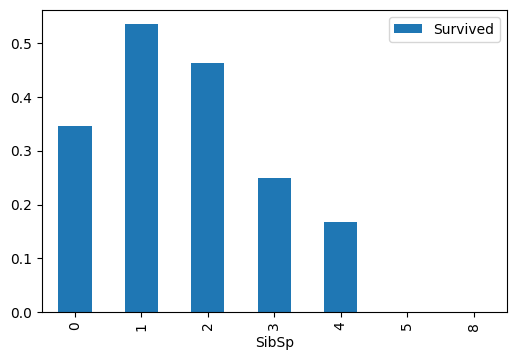

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

sibsp_pivot = pd.pivot_table(train, index='SibSp',values = 'Survived')

sibsp_pivot.plot.bar()

We can see that those passengers with 1 or 2 siblings/spouses aboard the Titanic tended to survive more than those with none or more than 2.

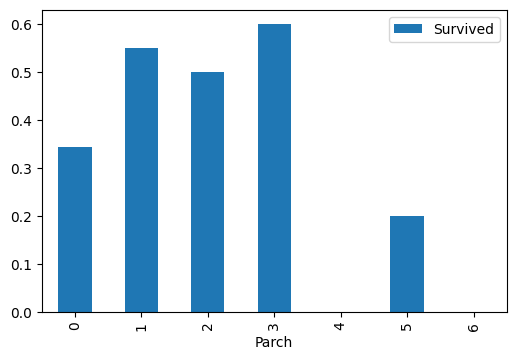

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

parch_pivot = pd.pivot_table(train, index='Parch',values = 'Survived')

parch_pivot.plot.bar()

We can see that passengers with 1 -3 parents or children aboard the ship tended to survive over those without any parents/children, and those with 5.  This could be due to the fact women and children were prioritised for survival. This would not explain why those with 5 children/parents survived much less often - perhaps there were very few passengers with so many relatives on boards and those who had more children tended to be poorer.

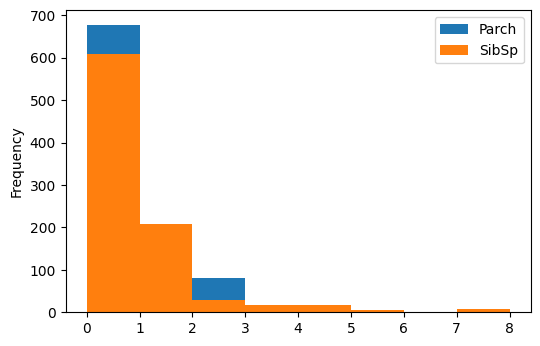

In [11]:
train[['Parch','SibSp']].plot.hist(bins=8)

We can see here that far and away the most common value was 0, which is interesting.  Perhaps we can combine both of these columns and see how the value varies with survival rate.

In [12]:
explore = train.copy()
explore['Family_size'] = explore[['SibSp','Parch']].sum(axis=1)

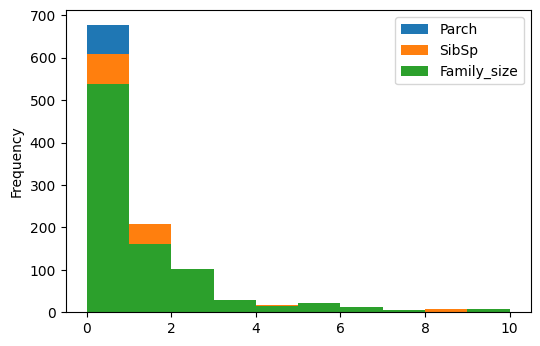

In [13]:
explore[['Parch','SibSp','Family_size']].plot.hist(bins=10)

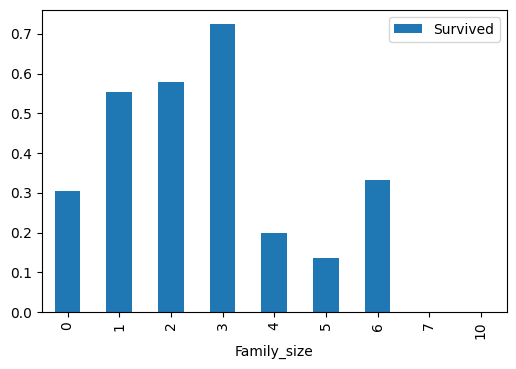

In [14]:
fs_pivot = pd.pivot_table(explore, index='Family_size',values = 'Survived')

fs_pivot.plot.bar()

We can see that those passengers with no family members had a much smaller chance of surviving than those with 1-3 family members. Interestingly past that the chance of surviving drops again.  Let's create a new feature which describes whether the passenger was alone or not - 1 if they had 0 family members onboard and 0 if the passenger has any family onboard.

# Creating the IsAlone Feature

In [15]:
def process_isalone(df):
    df['Family_size'] = df[['SibSp','Parch']].sum(axis=1)
    df['isalone'] = 0
    df.loc[(df['Family_size'] == 0), 'isalone'] = 1
    df = df.drop('Family_size',axis=1)
    return df

In [16]:
train = process_isalone(train)
holdout = process_isalone(holdout)

train.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,Cabin_type_C,Cabin_type_D,Cabin_type_E,Cabin_type_F,Cabin_type_G,Cabin_type_T,Cabin_type_Unknown,Sex_female,Sex_male,isalone
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,...,0,0,0,0,0,0,1,0,1,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,...,1,0,0,0,0,0,0,1,0,0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,...,0,0,0,0,0,0,1,1,0,1


# Selecting Optimal Features

We'll now use the RFECV class (which stands for Recursive Feature Elimination Cross Validation) to find and select the best features, as suboptimal feature selection can result in worse algorithm performance - as bad features can mislead the algorithm.

In [17]:
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestClassifier
import numpy as np

def select_features(df):
    #Creating a function which uses the Random Forest Model to select the most optimal features
    df = df.select_dtypes([np.number]).dropna(axis=1)
    all_X = df.drop(['PassengerId','Survived'], axis=1)
    all_y = df['Survived']
    
    rf = RandomForestClassifier(random_state=1)
    selector = RFECV(rf, cv=10)
    selector.fit(all_X, all_y)
    optimised_columns = all_X.columns[selector.support_]
    
    print(optimised_columns)
    return optimised_columns

In [18]:
best_columns = select_features(train)

Index(['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Age_categories_Missing',
       'Age_categories_Infant', 'Age_categories_Child',
       'Age_categories_Teenager', 'Age_categories_Young Adult',
       'Age_categories_Adult', 'Age_categories_Senior', 'Fare_categories_0-12',
       'Fare_categories_12-50', 'Fare_categories_50-100',
       'Fare_categories_100+', 'Title_Master', 'Title_Miss', 'Title_Mr',
       'Title_Mrs', 'Title_Officer', 'Cabin_type_A', 'Cabin_type_B',
       'Cabin_type_C', 'Cabin_type_D', 'Cabin_type_E', 'Cabin_type_Unknown',
       'Sex_female', 'Sex_male', 'isalone'],
      dtype='object')


# Selecting Algorithm and Optimising Hyperparameters

In [19]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

def select_model(df, features):
    all_X = df[features]
    all_y = df['Survived']
    #Creating a dictionary containing the three models we're using, along with all of the parameters we wish to test
    models = [
        {
            'name':'LogisticRegression',
            'estimator':LogisticRegression(),
            'hyperparameters':
            {
            'solver':["newton-cg", "lbfgs", "liblinear"]
                
            }
        },
        {
            'name':'KNeighborsClassifier',
            'estimator':KNeighborsClassifier(),
            'hyperparameters':
            {    
            "n_neighbors": range(1,20,2),    
            "weights": ["distance", "uniform"],   
            "algorithm": ["ball_tree", "kd_tree", "brute"],
            "p": [1,2]
            }
        },
        {
            'name':'RandomForestClassifier',
            'estimator':RandomForestClassifier(),
            'hyperparameters':
            {    
            "n_estimators": [4, 6, 9],    
            "criterion": ["entropy", "gini"],  
            "max_depth": [2, 5, 10],
            "max_features": ["log2", "sqrt"],
            "min_samples_leaf": [1, 5, 8],
            "min_samples_split": [2, 3, 5]
            }
        },
        
    ]
    
    for model in models:
        #Iterate through each model and print the best score, and best parameters for each model
        print(model['name'])
        grid = GridSearchCV(model['estimator'], param_grid=model['hyperparameters'], cv=10)
        grid.fit(all_X, all_y)
        
        model['best_params'] = grid.best_params_
        model['best_score'] = grid.best_score_
        model['best_model'] = grid.best_estimator_
        
        print('Best Score: {}'.format(model['best_score']))
        print('Best Parameters: {}\n'.format(model['best_params']))
        print('\n')
              
    return models

In [20]:
result = select_model(train, best_columns)

LogisticRegression


/dataquest/system/env/python3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

/dataquest/system/env/python3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

/dataquest/s

Best Score: 0.8204744069912608
Best Parameters: {'solver': 'lbfgs'}



KNeighborsClassifier
Best Score: 0.7767041198501874
Best Parameters: {'algorithm': 'brute', 'n_neighbors': 5, 'p': 1, 'weights': 'uniform'}



RandomForestClassifier
Best Score: 0.8350686641697879
Best Parameters: {'criterion': 'entropy', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 9}





After testing our 3 models and finding the best features, the model with the highest accuracy score ended up being the Random Forest model.

# Making a Submission File for Kaggle

In [23]:
def save_submission_file(model, best_columns, filename='submission.csv'):
    holdout_data = holdout[best_columns]
    predictions = model.predict(holdout_data)
    passenger_id = holdout['PassengerId']
    submission_dict = {'PassengerId':passenger_id, 'Survived':predictions}
    submission = pd.DataFrame(submission_dict)
    
    submission.to_csv(filename, index=False)
    
best_model = result[2]['best_model']
save_submission_file(best_model, best_columns)

This model ended up scoring 0.76315 on Kaggle, which actually isn't an improvement on my previous submissions.  However, I feel much more confident in using Python and creating a Data Science workflow than I did all those months ago.

Some things I aim to do in the future with this workbook include: 
* Using different models (such as XGBoost)

* Using RandomizedSearchCV instead of Grid Search to speed up code

* Performing feature engineering on different columns - making different features to train on